<h1><center>Introduction to quantum science and technology - QUANT 400</center></h1>

<p><center> <b>Lecturer:</b> <i>Prof. G. Carleo</i> </center><p>
    
<p><center> <b>Assistant: </b> <i>friederike.metz@epfl.ch

## Exercise 2 - Quantum computing

### Very brief introduction to Qiskit

[Qiskit](https://www.ibm.com/quantum/qiskit) is an open-source software for working with quantum computers at the level of quantum circuits, operators, and primitives.

See the [documentation](https://docs.quantum.ibm.com/) for more details.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp

The basic element needed for your first program is the [QuantumCircuit](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html).  We begin by creating a `QuantumCircuit` comprised of two qubits that start out in the $|00\rangle$ state.

In [2]:
# Create a Quantum Circuit acting on a quantum register of two qubits
circ = QuantumCircuit(2)

Let's add gates that prepare a Bell-state (i.e. a maximally entangled two-qubit state):

$$|\psi\rangle = \left(|00\rangle+|11\rangle\right)/\sqrt{2}$$

In [3]:
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting the qubits in a Bell state.
circ.cx(0, 1)

We can visualize the circuit

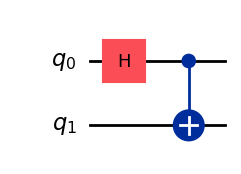

In [4]:
circ.draw('mpl')

For a full list of all gates that are available, check Qiskit's [circuit library](https://docs.quantum.ibm.com/api/qiskit/circuit_library).

We can extract the quantum state vector at the end of the circuit.

In [5]:
Statevector(circ)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


We can compute expectation values of observables using the `Estimator`. If you use the `StatevectorEstimator`, the expectation value is still calculated using the state vector representation of the quantum state.

In [6]:
estimator = StatevectorEstimator()
observable = Pauli('XX')
result = estimator.run([(circ, observable)]).result()[0]

In [7]:
print("Value:", result.data.evs)
print("Standard error:", result.data.stds)

Value: 0.9999999999999998
Standard error: 0.0


You can compute the expectation values of multiple observables by providing a list of them.

In [8]:
result = estimator.run([(circ, [Pauli('XX'), Pauli('IY')])]).result()[0]

In [9]:
print("Value:", result.data.evs)
print("Standard error:", result.data.stds)

Value: [1. 0.]
Standard error: [0. 0.]


In practice on a real quantum computer, we can only measure the qubits in the computational basis (i.e., eigenstates of the Pauli-$\hat{Z}$ operator) and obtain one of two possible outcomes for every qubit: 0, 1 corresponding to either the eigenvalue +1 (spin up) or eigenvalue -1 (spin down). The expectation values would then be computed by repeatedly running the circuit and measuring the qubits (possibly in different bases) and averaging over the measurement statistics. The more measurements (shots) you take, the more precise the expectation values can be estimated.

We can obtain this raw measurement data using the `Sampler`.

In [10]:
circ.measure_all() # we first need to specify which qubits are measured
sampler = StatevectorSampler()
result = sampler.run([circ], shots=10).result()[0]
counts = result.data.meas.get_counts()
counts

{'00': 8, '11': 2}

Let's visualize the number of times each different bitstring was measured. Note that if you rerun the cell above, the outcome will change each time as the measurement process is inherently probabilistic.

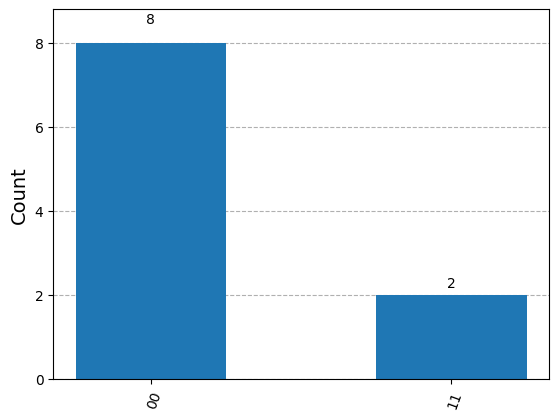

In [11]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

### Time evolution of a quantum spin model

Let's simulate the time evolution of the Ising model using qiskit. Recall the previous exercise in which we used the 2nd order Trotter-Suzuki decomposition to approximate the total evolution unitary as

$$ \exp (-i \hat{H} t) \approx \exp(-i \frac{\Delta_t}{2}  \hat H_\mathrm{Z Z}) \ldots \exp(-i \Delta_t \hat H_\mathrm{X})   \exp(-i \Delta_t \hat H_\mathrm{Z Z}) \ldots \exp(-i \Delta_t \hat H_\mathrm{X}) \exp(-i \frac{\Delta_t}{2}  \hat H_\mathrm{Z Z}) $$

In turn, each of these terms can be expressed as a product of commuting unitaries acting on one or two qubits only, e.g.,

$$\exp(-i \Delta_t \hat H_\mathrm{X}) = \prod_{i=1}^N \exp(-i \Delta_t \Gamma \hat{X}_i) = \prod_{i=1}^N R_{X_i}(2 \Delta_t \Gamma ).$$

$R_{X_i}$ denotes a rotation of qubit $i$ around the $X$ axis of the Bloch sphere. Note the extra factor of 2 since the definition of the $R_X$ gate in qiskit comes with a factor of 1/2.

In [12]:
def time_evol_circuit(N, t, dt, J, gamma):
    n_steps = round(t / dt) # number of Suzuki-Trotter steps
    circ = QuantumCircuit(N)
    for i in range(N-1): # N-1 because we assume open boundary conditions
        circ.rzz(2*J*dt/2, i, (i+1)%N)
    for step in range(n_steps-1):
        for i in range(N):
            circ.rx(2*gamma*dt, i)
        for i in range(N-1):
            circ.rzz(2*J*dt, i, (i+1)%N)
    for i in range(N):
        circ.rx(2*gamma*dt, i)
    for i in range(N-1):
        circ.rzz(2*J*dt/2, i, (i+1)%N)
    return circ

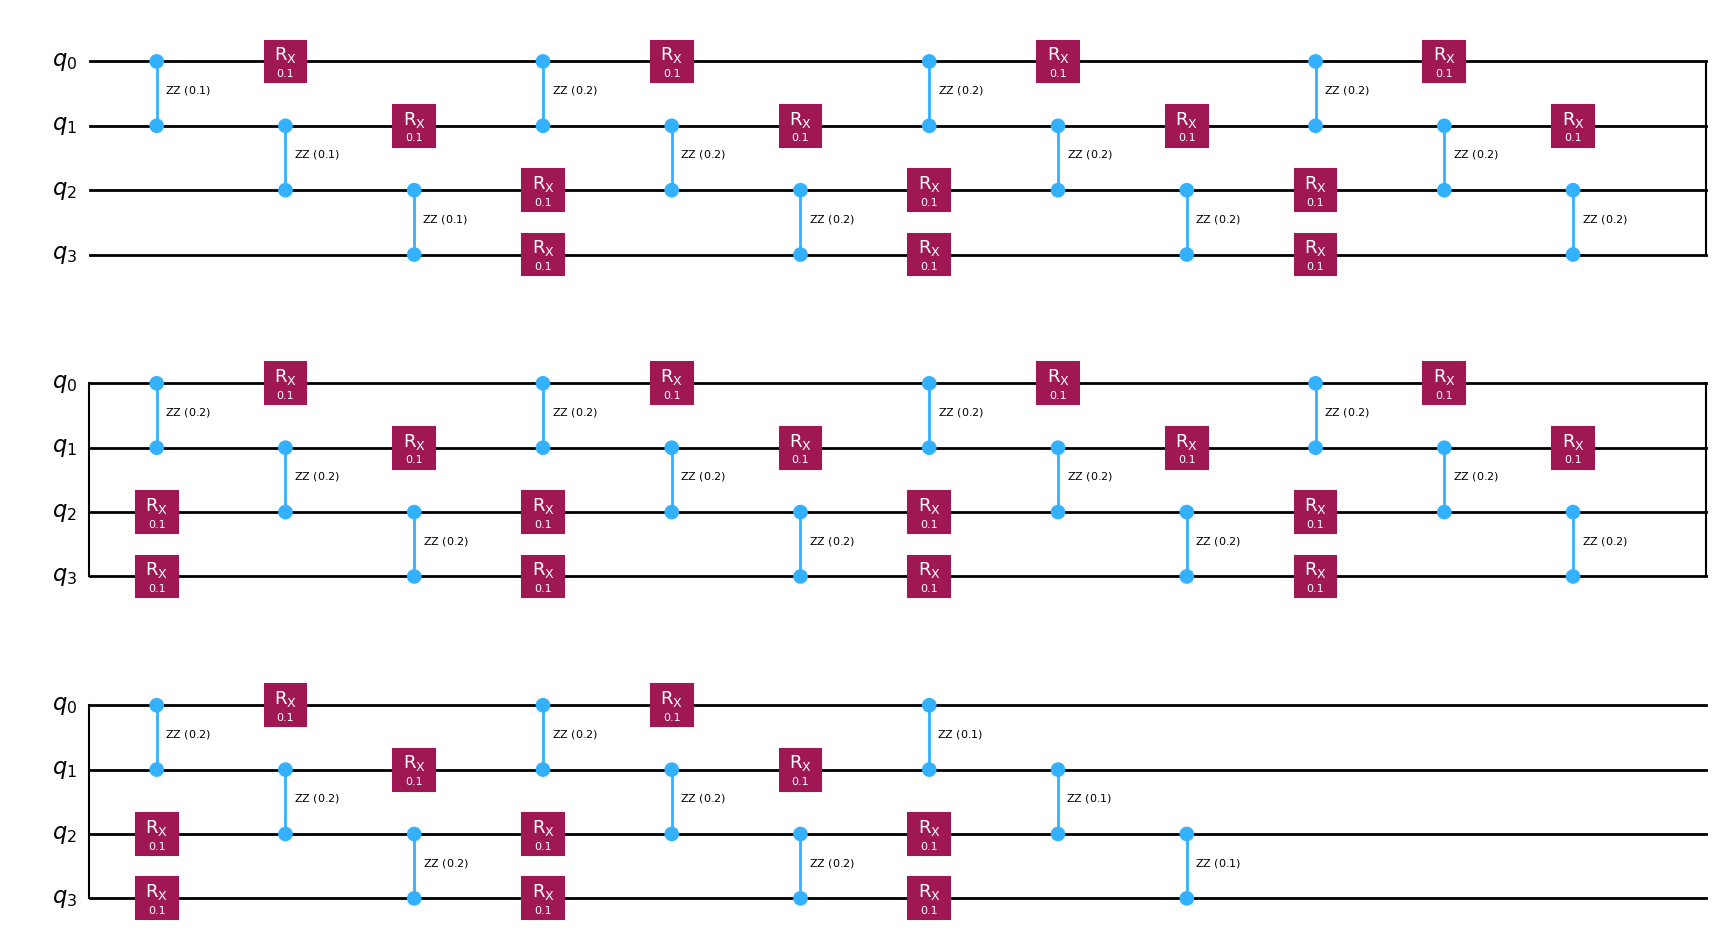

In [13]:
circ = time_evol_circuit(4, 1., 0.1, 1.0, 0.5)
circ.draw('mpl')

Starting from the $|0\dots 0\rangle$ initial state, let's measure the average magnetization along z-direction every 100 steps during the time evolution.

$$ \hat{O} = \frac 1 N \sum_i \hat{Z}_i$$

In [14]:
N = 5 # number of qubits
t = 10. # total evolution time
dt = 1e-2 # Trotter time step size (Delta t)
J = 1.0 # Ising coupling strength
gamma = 0.8 # Ising transverse field
n_points = 50 # number of time stamps at which we want to measure the expectation value of the observable
ts = np.linspace(0, t, n_points+1) # measure at these times

# generate 100 different circuits corresponding to 100 different evolution times
circuits = [time_evol_circuit(N, t, dt, J, gamma) for t in ts]

# define the observable we want to measure
obs_terms = [("Z", [i], 1/N) for i in range(N)]
observable = SparsePauliOp.from_sparse_list(obs_terms, num_qubits=N)
observable

SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII'],
              coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])

In [15]:
circuit_observable_pairs = [(circ, observable) for circ in circuits]
results = estimator.run(circuit_observable_pairs).result()
exp_values = [results[i].data.evs for i in range(n_points+1)]

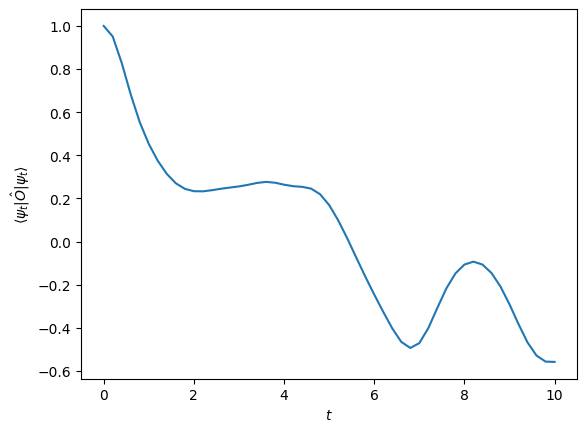

In [16]:
plt.figure()
plt.plot(ts, exp_values)
plt.xlabel("$t$")
plt.ylabel(r"$\langle \psi_t | \hat{O} | \psi_t \rangle$")
plt.show()

### Transpilation to native gates of the device

When writing a quantum circuit you are free to use any quantum gate (unitary operator) that you like, alongside with a collection of non-gate operations such as qubit measurements and reset operations. However, when running a circuit on a real quantum device one no longer has this flexibility. Due to limitations in, for example, the physical interactions between qubits, difficulty in implementing multi-qubit gates, control electronics, etc., a quantum computing device can only natively support a handful of quantum gates and non-gate operations. In the present case of [IBM Q devices](https://quantum-computing.ibm.com/services/resources?tab=systems), the native gate set can be found by querying the devices themselves, and looking for the corresponding attribute in their configuration.

In [17]:
from qiskit.providers.fake_provider import Fake5QV1, Fake20QV1

Fake5QV1().configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

Every quantum circuit run on an IBM Q device must be expressed using only these basis gates.

Let's take the following circuit as an example

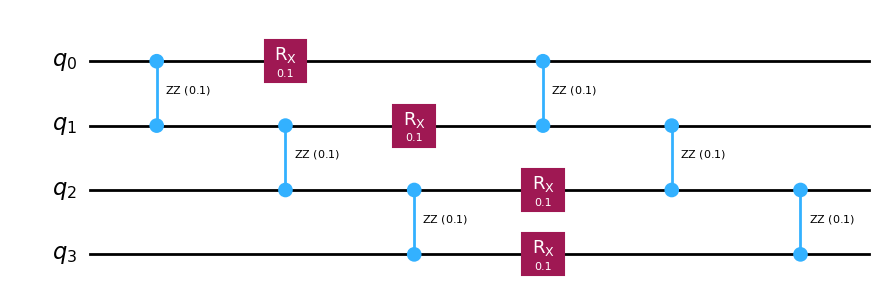

In [18]:
circ = time_evol_circuit(4, 0.1, 0.1, 1.0, 0.5)
circ.draw(output='mpl')

We have $R_{ZZ}$, and $R_X$ rotation gates, all of which are not in our devices basis gate set, and must be expanded. We can decompose the circuit to show what it would look like in the native gate set of the IBM Quantum devices.

/var/folders/g2/zp6r_4wd2jbb_yn3bzh8tqjh0000gq/T/ipykernel_57190/2126254506.py:6: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( fake_5q_v1 ) in the `backend` parameter in a future release no earlier than 2.0. `BackendV1` is deprecated and implementations should move to `BackendV2`.
  circ_transpiled = transpile(circ, backend)


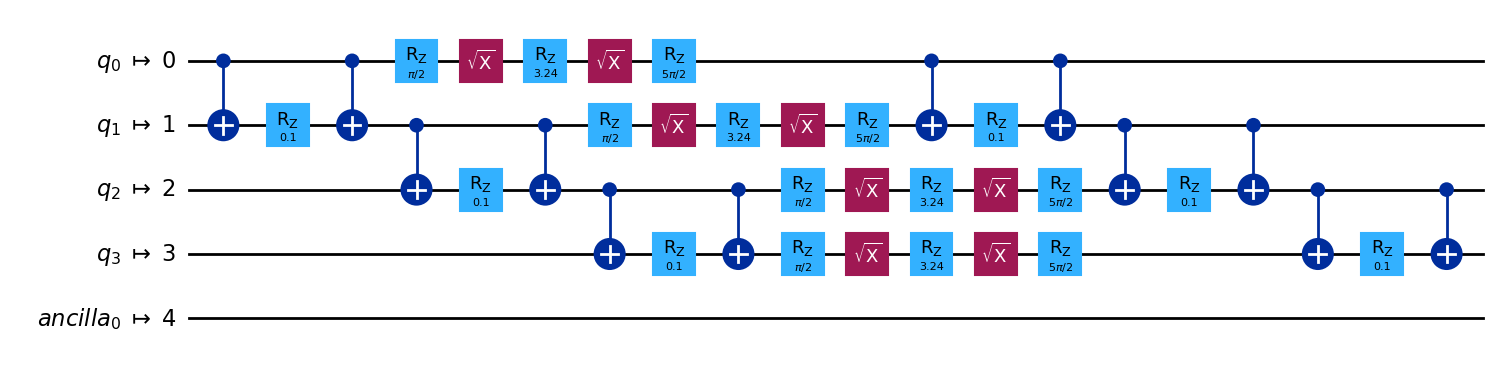

In [19]:
from qiskit import transpile

# backend = Fake20QV1()
backend = Fake5QV1()

circ_transpiled = transpile(circ, backend)
circ_transpiled.draw(output='mpl')

A few things to highlight. First, the circuit has gotten longer with respect to the initial one. Second, although we had only 12 two-qubit gates in the original circuit, the fact that those were not in the basis set means that, when expanded, it requires more than a single cx gate to implement. All said, unrolling to the basis set of gates leads to an increase in the depth of a quantum circuit and the number of gates. The deeper a circuit, the more noise and the bigger the errors our quantum states will be subject to. Keep this in mind when designing circuits that are run on real quantum devices!

In general, [transpilation](https://qiskit.org/documentation/apidoc/transpiler.html) is the process of rewriting a given input circuit to match the topology of a specific quantum device, and/or to optimize the circuit for execution on present day noisy quantum systems.

Most circuits must undergo a series of transformations that make them compatible with a given target device, and optimize them to reduce the effects of noise on the resulting outcomes. Rewriting quantum circuits to match hardware constraints and optimizing for performance can be far from trivial. The flow of logic in the rewriting tool chain need not be linear, and can often have iterative sub-loops, conditional branches, and other complex behaviors. The details are not important for you at this stage, just be aware that transpilation is an important but potentially very complex process.

### Problem 1: Noisy expectation values due to sampling

As mentioned earlier, the measurement outcome of a digital quantum computation are always bitstrings. If we want to compute the expectation value of some observable, in practice, we need to measure reapeatedly, collect all occurences of each measured bit(string), and then compute weighted averages over those. Hence, the result will necessary be noisy. In this exercise you will study how the number of measurements (shots) affects the standard error on the estimated expectation value.

a) Define a function that given a circuit and a specified number of shots/measurements returns the expectation value of the average z-magnetization

$$ \hat{O} = \frac 1 N \sum_i \hat{Z}_i$$

You can only use the `Sampler()` and not the `Estimator()` for this exercise.

In [20]:
def measure_average_sz_magnetization(circ, n_shots):
    circ.measure_all()
    sampler = StatevectorSampler()
    result = sampler.run([circ], shots=n_shots).result()[0]
    counts = result.data.meas.get_counts()
    # print(counts)

    avg_mag = 0
    for (bitstring, count) in counts.items():
        bits = np.array([int(bit) for bit in bitstring]) # convert characters in string to integer type
        szs = (-1)**(bits)
        avg_mag += np.mean(szs) * count / n_shots
    return avg_mag

Given a observable that is diagonal in the $Z$-basis: $\hat{O} = \sum_\mathbf{z} f(\mathbf{z}) |\mathbf{z}\rangle\langle \mathbf{z}|$ with possible measurement outcomes $f(\mathbf{z})$, the expectation value $\langle \psi |\hat{O}|\psi\rangle$ can be estimated as

$$ \langle \psi |\hat{O}|\psi\rangle \sim \frac{1}{M_s} \sum_{i=1}^{M_s} f(\mathbf{z}^{(i)}) ,$$

where $M_s$ is the number of measurements (shots) and $f(\mathbf{z}^{(i)})$ is the measurement outcome for the ith measurement.

If you measure the j-th qubit on the quantum device, $\hat{Z}_j = \sum_\mathbf{z} (-1)^{z_j} |\mathbf{z}\rangle\langle \mathbf{z}|$, so $f(\mathbf{z})=(-1)^{z_j}$.

(Note that in Qiskit 0 corresponds to eigenvalue +1 (spin up) and 1 to eigenvalue -1 (spin down).)

For the observable that is an average over all $\hat{Z}_i$ operators, we get

$$ \hat{O} = \frac 1 N \sum_i \hat{Z}_i = \sum_\mathbf{z} \frac{1}{N} \sum_i (-1)^{z_i} |\mathbf{z}\rangle\langle \mathbf{z}|, $$

such that $f(\mathbf{z}) = \frac 1 N \sum_i (-1)^{z_i}$.

For a single measured bistring $\mathbf{z}$, the `np.mean((-1)**(bits))` in the code above is computing this average. Now we still have to average over all the collected measurements, i.e. $\frac{1}{M_s} \sum_{j=1}^{M_s} f(\mathbf{z}^{(j)})$. So we have to sum over all bitstrings and if a bitstring appeared multiple times, we have to account for that in the sum (that's why we multiply by `count`). Finally we divide by the total number of shots $M_s$ (`n_shots`).

b) Given the circuit below, compute the expectation value a few times (~20) and then calculate the standard deviation over all individual results you obtained. Set the number of shots to 1000.

In [21]:
circ = time_evol_circuit(N, 10., dt, J, gamma)
result = []
for i in range(20):
    result.append(measure_average_sz_magnetization(circ, 1000))
np.std(result)

np.float64(0.016400048780415254)

c) Repeat the steps from above for different number of shots as specified below. Then plot the computed standard deviations against the number of shots.

In [22]:
n_shots_list = np.logspace(2, 5, 4, base=10, dtype=int)
stds = []
for n_shots in n_shots_list:
    result = []
    for i in range(20):
        result.append(measure_average_sz_magnetization(circ, n_shots))
    stds.append(np.std(result))

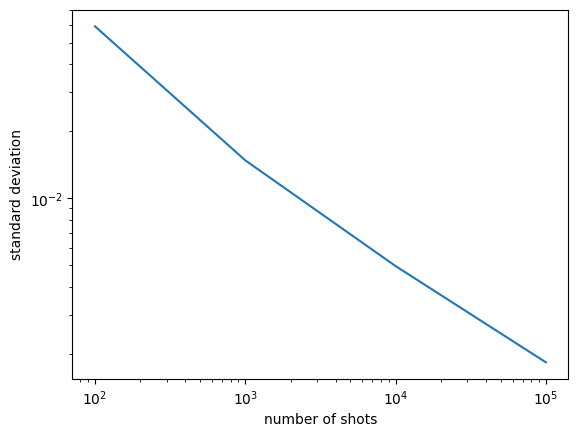

In [23]:
plt.figure()
plt.plot(n_shots_list, stds)
plt.loglog()
plt.xlabel("number of shots")
plt.ylabel("standard deviation")
plt.show()

d) Can you figure out a simple mathematical relationship of how the standard deviation of the mean scales with the number of shots? What implications does this have on results obtained from a quantum computation?

In [24]:
curve = np.polyfit(np.log(n_shots_list), np.log(stds), 1)
curve

array([-0.50062907, -0.6276524 ])

The slope of the linear regression is roughly 0.5. This means that $\sigma \sim 1/\sqrt{M_{shots}}$. You just rediscovered the general scaling law of the standard error of the sample mean with the sample size. This holds for any observable and circuit.

In general, you can estimate the standard error via

$$\sigma_{SE} = \frac{\sigma_{\hat{O}}}{\sqrt{M_{s}}},$$

and $\sigma_{\hat{O}}^2 = Var[\hat{O}] = \langle \psi |\hat{O}^2|\psi \rangle - \langle \psi |\hat{O}|\psi \rangle^2$ can be estimated via the sample standard deviation

$$\sigma_{\hat{O}}^2=\frac{1}{M_s-1} \sum_{i=1}^{M_s}\left(f(\mathbf{z}^{(i)})-\mu\right)^2 .  $$

In [25]:
def measure_average_sz_magnetization(circ, n_shots):
    circ.measure_all()
    sampler = StatevectorSampler()
    result = sampler.run([circ], shots=n_shots).result()[0]
    counts = result.data.meas.get_counts()

    avg_mag = 0
    for (bitstring, count) in counts.items():
        bits = np.array([int(bit) for bit in bitstring])
        szs = (-1)**(bits)
        avg_mag += np.mean(szs) * count / n_shots

    std_mag = 0
    for (bitstring, count) in counts.items():
        bits = np.array([int(bit) for bit in bitstring])
        szs = (-1)**(bits)
        std_mag += (np.mean(szs) - avg_mag)**2 * count / (n_shots - 1)

    return avg_mag, std_mag

In [26]:
results2 = [measure_average_sz_magnetization(circ, shots) for shots in n_shots_list]
results2 = np.array(results2)

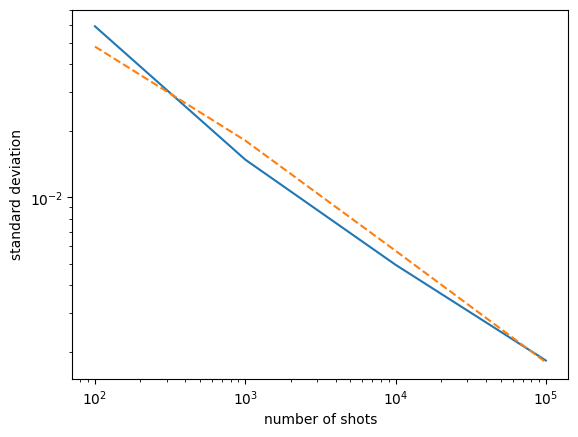

In [27]:
plt.figure()
plt.plot(n_shots_list, stds)
plt.plot(n_shots_list, np.sqrt(results2[:,1]/n_shots_list), linestyle='--')
plt.loglog()
plt.xlabel("number of shots")
plt.ylabel("standard deviation")
plt.show()

The purpose of this exercise was to show you that statistical uncertainties in measurements are a necessary evil in quantum computation. In practice, any quantum algorithm needs to be designed and understood using random variables, and any results you obtain should always include well-estimated uncertainties.

### Problem 2: Digitial adiabatic state preperation 

Let's turn to the problem of ground state preparation on quantum computers. One way of obtaining ground states is by __adiabatic time evolution__. Let's say that we know how to prepare the ground state of some Hamiltonian $H_i$ and our goal is to find the ground state of a different, more complicated Hamiltonian $H_f$. We then define a time-dependent Hamiltonian $H(t)$ that interpolates between the initial Hamiltonian $H_i$ and final Hamiltonian $H_f$, i.e.,

$$H(t) = (1-u(t)) H_i + u(t) H_f ,$$

where $u(t)$ is a smooth function of time which is 0 at $t=0$ and 1 at $t=T$. For example: $u(t) = t/T$.

The [adiabatic theorem](https://en.wikipedia.org/wiki/Adiabatic_theorem) then guarantees that we stay in the instantaneous ground state of $H(t)$ throughout the time evolution as long as we evolve slowly enough and as long as there is a gap between the ground and first excited state.

Let's apply the idea of adiabatic ground state preparation to our Ising model example. As an example imagine you want to prepare the ground state of $H_f = J \sum_i \hat{X}_i\hat{X}_{i+1} - \sum_i \hat{Z}_i$ for some fixed coupling strength $J$. We know that the initial state on a quantum computer is $|0\dots 0 \rangle$ which is exactly the ground state of the transverse-field Hamiltonian, i.e., $H_i = - \sum_i \hat{Z}_i$. Hence, we need to adiabatically evolve with the following time-dependent Hamiltonian:

$$H(t) = (1-u(t)) H_i + u(t) H_f = u(t) J \sum_i \hat{X}_i\hat{X}_{i+1} - \sum_i \hat{Z}_i .$$

So we adiabtically turn on the interaction term of the Ising model.

We now want to simulate the time evolution of our initial $|0\dots 0 \rangle$ state with the Hamiltonian above on a quantum device. Let's figure out how to do this step by step. First, we compute the propagator $G_{\Delta_t}(t)$ that evolves a quantum state at time $t$ by a small (infinitesimal) time increment $\Delta_t$:

$$ \ket{\Psi(t+\Delta_t)} = G_{\Delta_t}(t) \ket{\Psi(t)} =  e^{-i \Delta_t \bar{H}_t} \ket{\Psi(t)}.$$

a) Determine $\bar{H}_t$ up to first order in the Magnus expansion for the time-dependent Ising Hamiltonian above using pen and paper (no need to write code). Assume a linear ramp, i.e., $u(t)= t/T$ and open boundary conditions.

Remember from class that the first term in the Magnus expansion is just the time-averaged Hamiltonian, i.e., 

$$\bar{H}^{(1)}_t = \frac{1}{\Delta_t}\int_{t}^{t+\Delta_t} H(t') dt'$$

Integrating the Hamiltonian from above then gives:

$$ \bar{H}^{(1)}_t = - \sum_i \hat{Z}_i + \frac{J}{2T} (2t + \Delta_t) \sum_i \hat{X}_i\hat{X}_{i+1} \equiv H_Z + H_{XX}(t)$$

b) Assuming that $\Delta_t$ is small, use the first-order Trotter-Suzuki decomposition to split the propagator $G_{\Delta_t}(t)$ into a product of local terms (again using pen and paper).

How does the error of the obtained expression scale w.r.t. the exact time evolution?

$$ G_{\Delta_t}(t) = e^{-i\Delta_t \bar{H}^{(1)}_t} + \mathcal{O}\left(\Delta_t^2\right) = e^{-i\Delta_t H_Z} e^{-i\Delta_t H_{XX}(t)} + \mathcal{O}\left(\Delta_t^2\right) = \prod_i \exp({i\Delta_t \hat{Z}_i}) \prod_i \exp({-i \Delta_t\frac{ J}{2T}(2t + \Delta_t) \hat{X}_i\hat{X}_{i+1}}) + \mathcal{O}\left(\Delta_t^2\right)$$


The first-order Magnus expansion introduces an error of $\mathcal{O}\left(\Delta_t^2\right)$ for the propagator. Similarly, the first-order Trotter-Suzuki decomposition introduces an error on the order of $\Delta_t^2$ so the overall error still scales as $\Delta_t^2$.

c) Now write down the propagator $G(t)$ for the time evolution from time $t=0$ to $t=n_{steps} \Delta_t$ using the result above.

$$ \ket{\Psi(t)} = G(t) \ket{\Psi(0)} =  ... \ket{\Psi(0)}$$

$$G(t) = \prod_{n=0}^{n_{steps}-1}\left[\prod_{i=1}^{N}\exp(i\Delta_t \hat{Z}_i) \prod_{i=1}^{N-1}\exp(-i \frac{\Delta_t^2 J}{2T}(2n+1) \hat{X}_i\hat{X}_{i+1})\right]$$


d) Modify the function `time_evol_circuit` from above to the time-dependent case considered here.

Note that as before $N$ is the total number of spins/qubits, $t$ is the time up to which we want to evolve, $(T,J)$ are parameters in the Hamiltonian, and `dt` is the step size $\Delta_t$.

In [28]:
def adiabatic_time_evol_circuit(N, t, T, dt, J):
    n_steps = round(t / dt) # number of Suzuki-Trotter steps
    circ = QuantumCircuit(N)
    for step in range(n_steps):
        for i in range(N-1):
            circ.rxx(2*J*(2*(step) + 1)*dt**2/(2*T), i, (i+1)%N)
        for i in range(N):
            circ.rz(-2*dt, i)
    return circ

During the time evolution we want to measure the energy w.r.t. $H(t)$ to see if we actually stay in the instantaneous ground state at all times.

e) Define a function that given a time $t$ returns the Hamiltonian $H(t)$ as a `SparsePauliOp`. There are different ways of doing this, any one is fine.

In [29]:
def hamiltonian(N, t, T, J):
    h_terms = [("Z", [i], -1) for i in range(N)]
    h_terms += [("XX", [i, (i+1)%N], J*t/T) for i in range(N-1)]

    return SparsePauliOp.from_sparse_list(h_terms, num_qubits=N)

Now it's time to simulate the evolution and measure the energy of the Hamiltonian.

In [30]:
N = 5 # number of qubits
T = 1. # total evolution time
dt = 1e-2 # Trotter time step size (Delta t)
J = 0.5 # Ising coupling strength
n_points = 50 # number of time stamps at which we want to measure the expectation value of the observable
ts = np.linspace(0, T, n_points+1) # measure at these times
measured_energies = [] # store measured energies here

f) Use the `StatevectorEstimator` to run the circuits and measure the corresponding Hamiltonian $H(t)$ at all times `ts`. Plot the expectation values as a function of time $t$.

In [31]:
estimator = StatevectorEstimator()
circuit_observable_pairs = [(adiabatic_time_evol_circuit(N, t, T, dt, J), hamiltonian(N, t, T, J)) for t in ts]
results = estimator.run(circuit_observable_pairs).result()
measured_energies = [results[i].data.evs for i in range(n_points+1)]

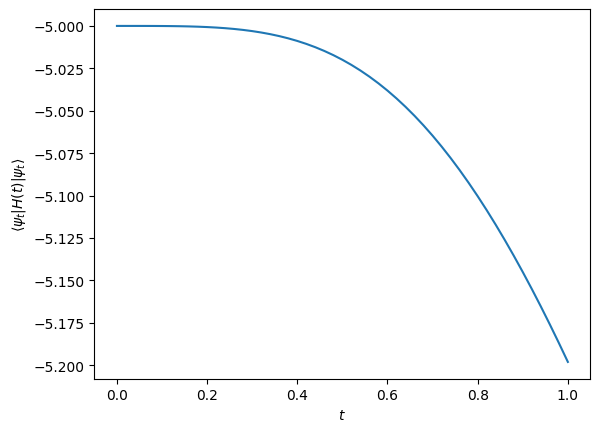

In [32]:
plt.figure()
plt.plot(ts, measured_energies)
plt.xlabel("$t$")
plt.ylabel(r"$\langle \psi_t | H(t) | \psi_t \rangle $")
plt.show()

g) To see whether we actually stay in the instantaneous ground state of $H(t)$ compute the true ground state at all times $t$ using exact diagonalization. Plot the results on top of the figure above.

Note that you can convert a `SparsePauliOp` to a sparse matrix format using the `to_matrix(sparse=True)` method.

In [33]:
from scipy.sparse.linalg import eigsh
exact_energies = []
for t in ts:
    H = hamiltonian(N, t, T, J).to_matrix(sparse=True)
    E_ed = np.sort(eigsh(H, k=4, which="SA", return_eigenvectors=False))
    exact_energies.append(E_ed[0])

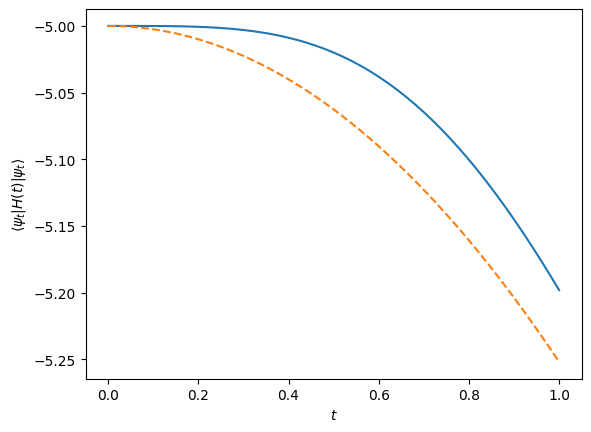

In [34]:
plt.figure()
plt.plot(ts, measured_energies)
plt.plot(ts, exact_energies, linestyle="--")
plt.xlabel("$t$")
plt.ylabel(r"$\langle \psi_t | H(t) | \psi_t \rangle $")
plt.show()

h) Why do the two curves deviate at longer times? What parameters can you change to follow the instantaneous ground state all the way to the final time $t=T$ more accurately? Try it out!

<details><summary>💡Hint</summary>

Recall the adiabatic theorem and it's conditions.
</details>

We stay in the instantaneous ground state only if we evolve slowly, otherwise we excite the system. So increase the total evolution time to, for example, $T=10$.

i) 🚀Advanced: Critical slowing down

One can show that the total required evolution time $T$ of an adiabatic protocol has to be larger than the inverse squared energy gap between ground and first excited state at any point during the evolution:

$$ T \geq \frac{C}{\Delta^2}, \qquad \Delta = E_1 - E_0 ,$$

where $C$ is some constant.

Now imagine you want to prepare the ground state of the Ising model at the critical point $J/\Gamma = 1$ for an infinitely-large spin chain using adiabatic evolution. How long would you have to evovle for? You can answer this question by pure reasoning, however, feel free to calculate (analytically or numerically) what happens to $T$ when you increase the number of spins $N$. The previous tutorial might help you in that case.

Intuitively, why does adiabatic state preparation break down when it crosses a phase transition?

The Ising model has a phase transition at $J/\Gamma = 1$ which means that, in the thermodynamic limit, $\Delta \rightarrow 0$ exactly at the critical point. This means that the total evolution time $T\rightarrow \infty$ and thus, we would have to evolve infinitely slowly. This is commonly referred to as "critical slowing down". The closer you get to a phase transition (and the larger the system), the longer you need to evolve to stay in the instantaneous ground state.